In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf

# audio features
import librosa
import librosa.display

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# =========================
# QUICK RUN CONFIG
# =========================
QUICK_RUN = True          # Zet False op server / echte training
EPOCHS = 5                # Kleine sanity training
BATCH_SIZE = 8            # Lager = minder kans op OOM
SEED = 42

# Voor QUICK_RUN: neem een kleine, gebalanceerde subset
SAMPLES_PER_CLASS = 886   # 250*4 = 1000 samples totaal (pas aan indien nodig)

In [2]:
CSV_PATH = Path("../../data/processed/icbhi/icbhi_event_segments_100ms.csv")
WAV_DIR  = Path("../../data/processed/icbhi/audio_4000hz_bp_event_segments_100ms")

print("CSV_PATH:", CSV_PATH.resolve())
print("WAV_DIR :", WAV_DIR.resolve())
print("WAV_DIR exists:", WAV_DIR.exists())

CSV_PATH: C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\icbhi\icbhi_event_segments_100ms.csv
WAV_DIR : C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\icbhi\audio_4000hz_bp_event_segments_100ms
WAV_DIR exists: True


In [3]:
segments_df = pd.read_csv(CSV_PATH)
segments_df["wav_path"] = segments_df["segment_file"].apply(lambda x: str(WAV_DIR / x))

# Labels nu: normal / crackle / wheeze (3 classes)
segments_df = segments_df[segments_df["acoustic_label"].isin(["normal","crackle","wheeze"])].copy()

print("Rows:", len(segments_df))
display(segments_df.head())

Rows: 5262


,record_id,file_name,segment_index,seg_start_sec,seg_end_sec,seg_duration_sec,acoustic_label,frac_normal,frac_wheeze,frac_crackle,frac_crackle_wheeze,patient_id,diagnosis,chest_location,segment_file,wav_path
0,103_2b2_Ar_mc_LittC2SE,103_2b2_Ar_mc_LittC2SE.wav,0,1.75700,1.85700,0.1,wheeze,0.0,1.0,0.0,0.0,103,Asthma,Ar,103_2b2_Ar_mc_LittC2SE_evt00000_wheeze.wav,..\..\data\processed\icbhi\audio_4000hz_bp_eve...
1,103_2b2_Ar_mc_LittC2SE,103_2b2_Ar_mc_LittC2SE.wav,1,8.85750,8.95750,0.1,wheeze,0.0,1.0,0.0,0.0,103,Asthma,Ar,103_2b2_Ar_mc_LittC2SE_evt00001_wheeze.wav,..\..\data\processed\icbhi\audio_4000hz_bp_eve...
2,103_2b2_Ar_mc_LittC2SE,103_2b2_Ar_mc_LittC2SE.wav,2,12.66450,12.76450,0.1,wheeze,0.0,1.0,0.0,0.0,103,Asthma,Ar,103_2b2_Ar_mc_LittC2SE_evt00002_wheeze.wav,..\..\data\processed\icbhi\audio_4000hz_bp_eve...
3,103_2b2_Ar_mc_LittC2SE,103_2b2_Ar_mc_LittC2SE.wav,3,15.57150,15.67150,0.1,wheeze,0.0,1.0,0.0,0.0,103,Asthma,Ar,103_2b2_Ar_mc_LittC2SE_evt00003_wheeze.wav,..\..\data\processed\icbhi\audio_4000hz_bp_eve...
4,103_2b2_Ar_mc_LittC2SE,103_2b2_Ar_mc_LittC2SE.wav,0,18.26875,18.36875,0.1,normal,1.0,0.0,0.0,0.0,103,Asthma,Ar,103_2b2_Ar_mc_LittC2SE_n00000_normal.wav,..\..\data\processed\icbhi\audio_4000hz_bp_eve...


In [4]:
exists_mask = segments_df["wav_path"].apply(lambda p: Path(p).exists())
missing = segments_df.loc[~exists_mask, ["record_id", "segment_index", "wav_path"]]

print("Missing wavs:", len(missing))
if len(missing):
    display(missing.head(50))


Missing wavs: 0


In [5]:
# neem 1 voorbeeld (of kies zelf een index)
row = segments_df.sample(1, random_state=42).iloc[0]
wav_path = row["wav_path"]

y, sr = sf.read(wav_path, dtype="float32")
print("Example:", wav_path)
print("y shape:", y.shape, "| sr:", sr, "| duration:", len(y)/sr, "sec")


Example: ..\..\data\processed\icbhi\audio_4000hz_bp_event_segments_100ms\154_4b4_Ar_mc_AKGC417L_evt00005_crackle.wav
y shape: (400,) | sr: 4000 | duration: 0.1 sec


In [6]:
# =========================
# QUICK RUN: balanced subset
# =========================
rng = np.random.default_rng(SEED)

segments_df["acoustic_label"] = segments_df["acoustic_label"].astype(str).str.strip().str.lower()

valid = {"normal", "crackle", "wheeze"}
segments_df = segments_df[segments_df["acoustic_label"].isin(valid)].copy()

# Drop rows waarvan wav niet bestaat
exists_mask = segments_df["wav_path"].apply(lambda p: Path(p).exists())
segments_df = segments_df[exists_mask].copy()

print("Before QUICK_RUN filter:", len(segments_df))
print(segments_df["acoustic_label"].value_counts())

if QUICK_RUN:
    parts = []
    for lab in ["normal", "crackle", "wheeze"]:
        df_lab = segments_df[segments_df["acoustic_label"] == lab]
        n = min(SAMPLES_PER_CLASS, len(df_lab))
        if n == 0:
            print(f"[warn] No samples for class '{lab}' in current data.")
            continue
        parts.append(df_lab.sample(n=n, random_state=SEED))
    segments_df = pd.concat(parts, axis=0).sample(frac=1.0, random_state=SEED).reset_index(drop=True)

    print("\nAfter QUICK_RUN filter:", len(segments_df))
    print(segments_df["acoustic_label"].value_counts())


Before QUICK_RUN filter: 5262
acoustic_label
normal     2512
crackle    1864
wheeze      886
Name: count, dtype: int64

After QUICK_RUN filter: 2658
acoustic_label
normal     886
crackle    886
wheeze     886
Name: count, dtype: int64


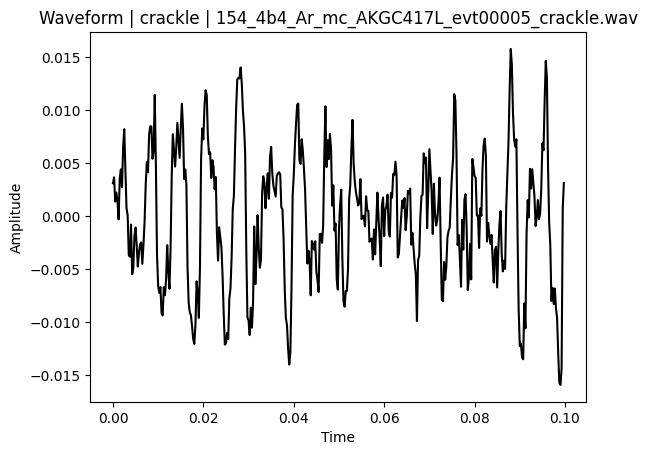

In [7]:
plt.figure()
time = np.arange(len(y)) / sr
plt.plot(time, y, color="k")
plt.title(f"Waveform | {row['acoustic_label']} | {Path(wav_path).name}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


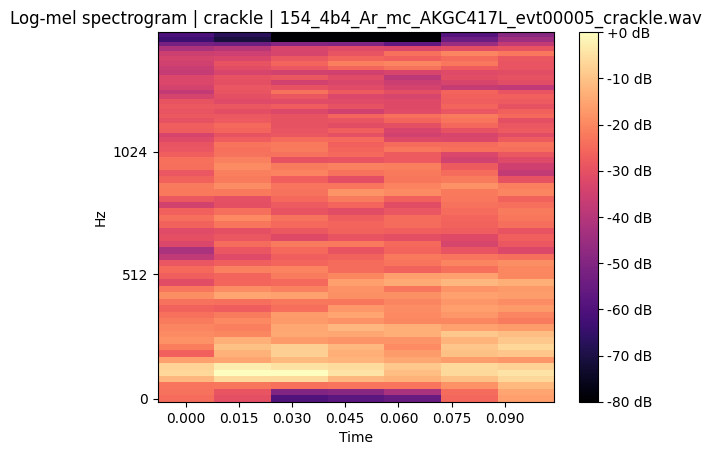

In [8]:
# log-mel params (baseline; later tunen in experiments)
n_fft = 256
hop_length = 64
n_mels = 64
fmin = 20
fmax = sr / 2

S = librosa.feature.melspectrogram(
    y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
    n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
)
S_db = librosa.power_to_db(S, ref=np.max)

plt.figure()
librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title(f"Log-mel spectrogram | {row['acoustic_label']} | {Path(wav_path).name}")
plt.show()


In [9]:
# normaliseer labels (voor het geval er hoofdletters/spaties bestaan)
segments_df["acoustic_label"] = segments_df["acoustic_label"].astype(str).str.strip().str.lower()

# verwachte set
valid = {"normal", "crackle", "wheeze"}
bad = sorted(set(segments_df["acoustic_label"]) - valid)
print("Rows after dropping unexpected labels:", len(segments_df))
print("Unexpected labels:", bad)

# drop reject
segments_df = segments_df[segments_df["acoustic_label"].isin(valid)].copy()
print("Rows after dropping unexpected labels:", len(segments_df))


Rows after dropping unexpected labels: 2658
Unexpected labels: []
Rows after dropping unexpected labels: 2658


In [10]:
print("Training dataset check:")
print("N rows:", len(segments_df))
print("Label counts:\n", segments_df["acoustic_label"].value_counts())
print("Unique patients:", segments_df["patient_id"].nunique())
print("Example wav_path:", segments_df["wav_path"].iloc[0])

Training dataset check:
N rows: 2658
Label counts:
 acoustic_label
normal     886
crackle    886
wheeze     886
Name: count, dtype: int64
Unique patients: 91
Example wav_path: ..\..\data\processed\icbhi\audio_4000hz_bp_event_segments_100ms\178_1b2_Lr_mc_AKGC417L_n00006_normal.wav


In [11]:
# encode labels -> one-hot
le = LabelEncoder()
y_int = le.fit_transform(segments_df["acoustic_label"])
y_onehot = keras.utils.to_categorical(y_int, num_classes=len(le.classes_))

print("Classes:", list(le.classes_))

Classes: ['crackle', 'normal', 'wheeze']


In [12]:
print("le.classes_:", le.classes_)
print("Example labels:", segments_df["acoustic_label"].head(10).tolist())

# Check dat y_onehot index klopt met le.classes_
i = 0
print("Row 0 label:", segments_df["acoustic_label"].iloc[i])
print("Row 0 y_int:", y_int[i])
print("Row 0 onehot argmax:", np.argmax(y_onehot[i]))
print("Row 0 decoded:", le.inverse_transform([np.argmax(y_onehot[i])])[0])


le.classes_: ['crackle' 'normal' 'wheeze']
Example labels: ['normal', 'normal', 'crackle', 'crackle', 'normal', 'normal', 'wheeze', 'normal', 'normal', 'normal']
Row 0 label: normal
Row 0 y_int: 1
Row 0 onehot argmax: 1
Row 0 decoded: normal


In [13]:
from sklearn.model_selection import train_test_split

labels = segments_df["acoustic_label"].values
idx = np.arange(len(labels))

train_idx, val_idx = train_test_split(
    idx,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Overall counts:\n", pd.Series(labels).value_counts())
print("\nTrain counts:\n", pd.Series(labels[train_idx]).value_counts())
print("\nVal counts:\n", pd.Series(labels[val_idx]).value_counts())

Overall counts:
 normal     886
crackle    886
wheeze     886
Name: count, dtype: int64

Train counts:
 normal     709
crackle    709
wheeze     708
Name: count, dtype: int64

Val counts:
 wheeze     178
crackle    177
normal     177
Name: count, dtype: int64


In [14]:
from tensorflow.keras.utils import to_categorical

# encode labels
le = LabelEncoder()
y_int = le.fit_transform(labels)
y_onehot = to_categorical(y_int, num_classes=len(le.classes_))

y_train = y_onehot[train_idx]
y_val   = y_onehot[val_idx]

print("Classes:", list(le.classes_))
print("y_train shape:", y_train.shape)
print("y_val shape  :", y_val.shape)

Classes: ['crackle', 'normal', 'wheeze']
y_train shape: (2126, 3)
y_val shape  : (532, 3)


In [15]:
print("Total:", len(segments_df))
print("Overall counts:\n", segments_df["acoustic_label"].value_counts())

# after your train/val split:
train_labels = le.inverse_transform(np.argmax(y_train, axis=1))
val_labels   = le.inverse_transform(np.argmax(y_val, axis=1))

print("\nTrain counts:\n", pd.Series(train_labels).value_counts())
print("\nVal counts:\n", pd.Series(val_labels).value_counts())

Total: 2658
Overall counts:
 acoustic_label
normal     886
crackle    886
wheeze     886
Name: count, dtype: int64

Train counts:
 normal     709
crackle    709
wheeze     708
Name: count, dtype: int64

Val counts:
 wheeze     178
crackle    177
normal     177
Name: count, dtype: int64


In [16]:
def logmel_01_from_wav_event(
    path,
    sr_expected=4000,
    n_fft=128,
    hop_length=32,
    n_mels=40,
    fmin=20,
    fmax=None,
):
    y, sr = sf.read(path, dtype="float32")
    if sr_expected is not None and sr != sr_expected:
        raise ValueError(f"Unexpected sr: {sr} != {sr_expected} for {path}")

    if fmax is None:
        fmax = sr / 2

    S = librosa.feature.melspectrogram(
        y=y, sr=sr,
        n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax,
        power=2.0
    )
    S_db = librosa.power_to_db(S, ref=1.0)          # absolute ref
    S_db = np.clip(S_db, -80.0, 0.0)                # fixed dB range
    X = (S_db + 80.0) / 80.0                        # -> [0,1]
    return X.astype(np.float32)[..., np.newaxis]    # (n_mels, n_frames, 1)

In [17]:
# zet je map goed
WAV_DIR = Path("../../data/processed/icbhi/audio_4000hz_bp_event_segments_100ms")

# maak wav_path kolom
segments_df["wav_path"] = segments_df["segment_file"].apply(lambda f: str(WAV_DIR / f))

# check dat files bestaan
exists_mask = segments_df["wav_path"].apply(lambda p: Path(p).exists())
missing = segments_df.loc[~exists_mask, ["segment_file", "wav_path"]]

print("Missing wav files:", len(missing))
if len(missing) > 0:
    display(missing.head(20))
    raise RuntimeError("Some wav files are missing; fix paths first.")

# build X
X_list = []
for p in segments_df["wav_path"].tolist():
    X_list.append(logmel_01_from_wav_event(p))

X = np.stack(X_list, axis=0)

print("X shape:", X.shape)
print("X dtype:", X.dtype)
print("X size (GB):", X.nbytes / 1e9)

Missing wav files: 0
X shape: (2658, 40, 13, 1)
X dtype: float32
X size (GB): 0.00552864


In [18]:
patients = segments_df["patient_id"].astype(str).values
unique_patients = np.unique(patients)

train_p, val_p = train_test_split(unique_patients, test_size=0.2, random_state=42, shuffle=True)

train_mask = np.isin(patients, train_p)
val_mask   = np.isin(patients, val_p)

X_train, X_val = X[train_mask], X[val_mask]
y_train, y_val = y_onehot[train_mask], y_onehot[val_mask]

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)


Train: (2079, 40, 13, 1) (2079, 3)
Val  : (579, 40, 13, 1) (579, 3)


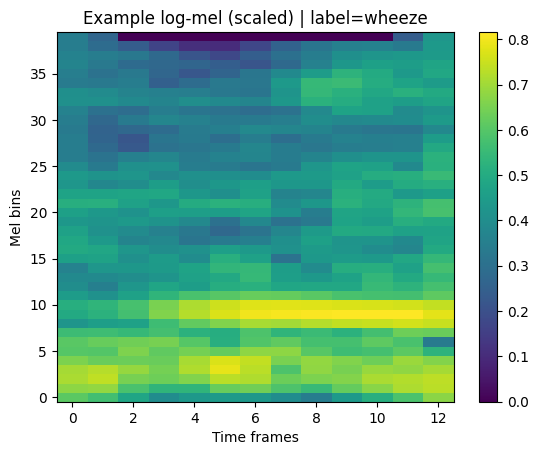

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(X_train[0, :, :, 0], aspect="auto", origin="lower")
plt.title(f"Example log-mel (scaled) | label={segments_df['acoustic_label'].iloc[train_idx[0]]}")
plt.xlabel("Time frames")
plt.ylabel("Mel bins")
plt.colorbar()
plt.show()


In [20]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=input_shape),

    layers.Conv2D(32, kernel_size=(4,2), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2,1), strides=(2,1), padding="valid"),

    layers.Conv2D(64, kernel_size=(4,2), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2,1), strides=(2,1), padding="valid"),

    layers.Conv2D(128, kernel_size=(4,2), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2,1), strides=(2,1), padding="valid"),

    layers.Conv2D(256, kernel_size=(4,2), activation="relu", padding="same"),
    layers.MaxPooling2D(pool_size=(2,1), strides=(1,1), padding="valid"),  # behoud tijd

    layers.Flatten(),
    layers.Dense(512, activation="relu"),   # 2000 is vaak overkill voor event-level
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax"),
])

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 13, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 13, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 13, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 13, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 13, 256)     │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,816,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,162,595 (27.32 MB)

 Trainable params: 7,162,595 (27.32 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
epochs=EPOCHS,
batch_size=BATCH_SIZE,

early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early],
    verbose=1
)



Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.3531 - loss: 1.0982 - val_accuracy: 0.2815 - val_loss: 1.1251
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4252 - loss: 1.0673 - val_accuracy: 0.3092 - val_loss: 1.1771
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.4377 - loss: 1.0464 - val_accuracy: 0.3143 - val_loss: 1.1623
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4329 - loss: 1.0500 - val_accuracy: 0.3264 - val_loss: 1.1373
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4526 - loss: 1.0298 - val_accuracy: 0.2781 - val_loss: 1.1587


In [22]:
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print("Val loss:", val_loss)
print("Val acc :", val_acc)


Val loss: 1.1250942945480347
Val acc : 0.2815198600292206


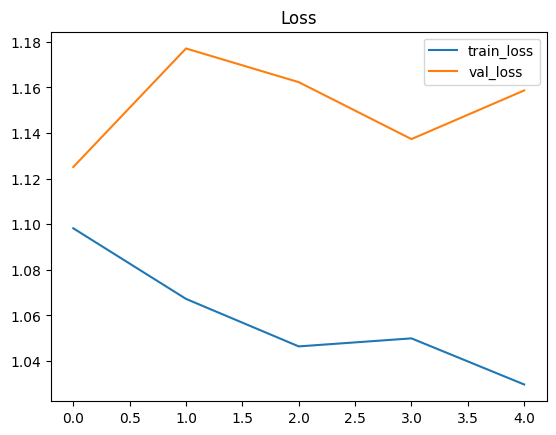

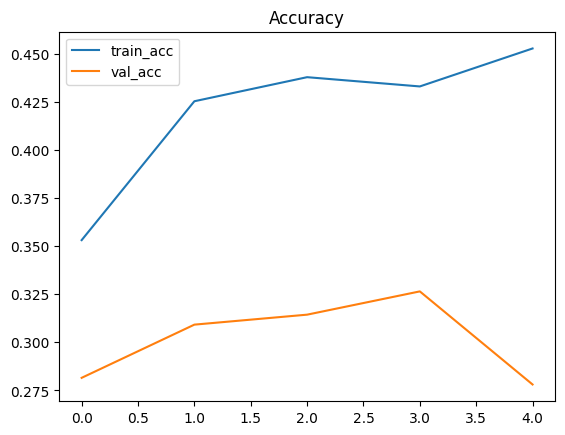

In [23]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()


In [24]:
pred = model.predict(X_val, verbose=0)
pred_int = np.argmax(pred, axis=1)
true_int = np.argmax(y_val, axis=1)

print("Pred label distribution:", pd.Series(pred_int).value_counts().sort_index().to_dict())
print("True label distribution:", pd.Series(true_int).value_counts().sort_index().to_dict())

print("Pred decoded:", pd.Series(le.inverse_transform(pred_int)).value_counts())
print("True decoded:", pd.Series(le.inverse_transform(true_int)).value_counts())


Pred label distribution: {1: 475, 2: 104}
True label distribution: {0: 170, 1: 173, 2: 236}
Pred decoded: normal    475
wheeze    104
Name: count, dtype: int64
True decoded: wheeze     236
normal     173
crackle    170
Name: count, dtype: int64


In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.tight_layout()
    plt.show()


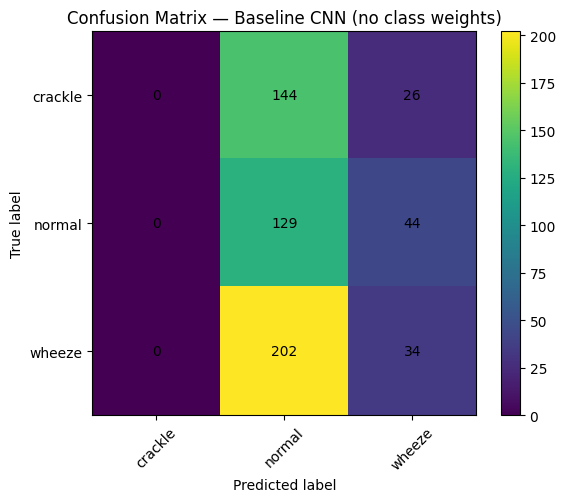

In [26]:
# Ground truth (val)
y_true = np.argmax(y_val, axis=1)

# Predictions
y_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)

plot_confusion_matrix(
    y_true,
    y_pred,
    class_names=le.classes_,
    title="Confusion Matrix — Baseline CNN (no class weights)"
)

In [27]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 40, 13, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 20, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 20, 13, 64)     │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 13, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 13, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 13, 256)     │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 13, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 13312)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,816,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,162,595 (27.32 MB)

 Trainable params: 7,162,595 (27.32 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# y_int heb je al (LabelEncoder output), maak train/val indices opnieuw consistent
# We bouwen y_int_train/y_int_val op basis van dezelfde masks die je eerder gebruikte.
y_int_train = y_int[train_mask]
y_int_val   = y_int[val_mask]

In [29]:
# class weights (balanced)
classes = np.unique(y_int_train)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_int_train)
class_weight = {int(c): float(w) for c, w in zip(classes, weights)}

print("Classes:", list(le.classes_))
print("Class counts (train):", {int(c): int((y_int_train == c).sum()) for c in classes})
print("Class weights:", class_weight)

Classes: ['crackle', 'normal', 'wheeze']
Class counts (train): {0: 716, 1: 713, 2: 650}
Class weights: {0: 0.9678770949720671, 1: 0.9719495091164095, 2: 1.0661538461538462}


In [30]:
# Early stopping (optioneel, maar nuttig)
early = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# Nieuwe training met class weights
history_w = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[early],
    verbose=1
)


Epoch 1/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.4286 - loss: 1.0672 - val_accuracy: 0.3195 - val_loss: 1.1305
Epoch 2/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4435 - loss: 1.0466 - val_accuracy: 0.3230 - val_loss: 1.1325
Epoch 3/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4367 - loss: 1.0383 - val_accuracy: 0.3299 - val_loss: 1.2043
Epoch 4/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.4478 - loss: 1.0341 - val_accuracy: 0.3212 - val_loss: 1.1276
Epoch 5/5
260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.4526 - loss: 1.0302 - val_accuracy: 0.3316 - val_loss: 1.1598


In [31]:
# Evaluatie
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print("Val loss:", val_loss)
print("Val acc :", val_acc)

Val loss: 1.1276100873947144
Val acc : 0.3212435245513916


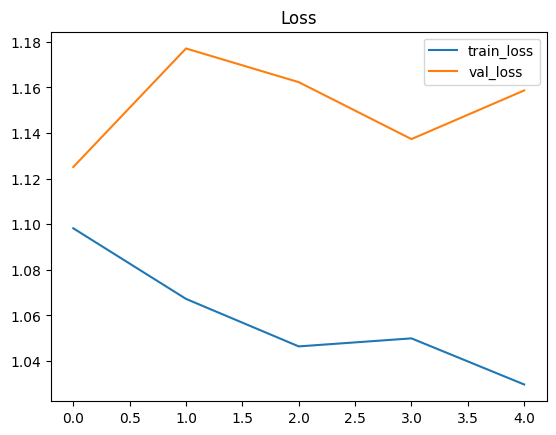

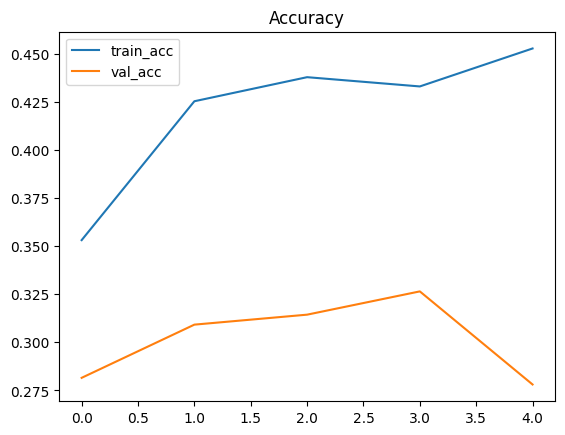

In [32]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Accuracy")
plt.show()


In [33]:
pred = model.predict(X_val, verbose=0)
pred_int = np.argmax(pred, axis=1)
true_int = np.argmax(y_val, axis=1)

print("Pred label distribution:", pd.Series(pred_int).value_counts().sort_index().to_dict())
print("True label distribution:", pd.Series(true_int).value_counts().sort_index().to_dict())

print("Pred decoded:", pd.Series(le.inverse_transform(pred_int)).value_counts())
print("True decoded:", pd.Series(le.inverse_transform(true_int)).value_counts())

Pred label distribution: {0: 541, 1: 35, 2: 3}
True label distribution: {0: 170, 1: 173, 2: 236}
Pred decoded: crackle    541
normal      35
wheeze       3
Name: count, dtype: int64
True decoded: wheeze     236
normal     173
crackle    170
Name: count, dtype: int64


In [34]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.colorbar()

    ticks = np.arange(len(class_names))
    plt.xticks(ticks, class_names, rotation=45)
    plt.yticks(ticks, class_names)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            plt.text(j, i, cm[i, j], ha="center", va="center")

    plt.tight_layout()
    plt.show()

In [35]:
pred = model.predict(X_val, verbose=0)
pred_int = np.argmax(pred, axis=1)
true_int = np.argmax(y_val, axis=1)

print("Pred label distribution:", pd.Series(pred_int).value_counts().sort_index().to_dict())
print("True label distribution:", pd.Series(true_int).value_counts().sort_index().to_dict())

print("Pred decoded:", pd.Series(le.inverse_transform(pred_int)).value_counts())
print("True decoded:", pd.Series(le.inverse_transform(true_int)).value_counts())

Pred label distribution: {0: 541, 1: 35, 2: 3}
True label distribution: {0: 170, 1: 173, 2: 236}
Pred decoded: crackle    541
normal      35
wheeze       3
Name: count, dtype: int64
True decoded: wheeze     236
normal     173
crackle    170
Name: count, dtype: int64


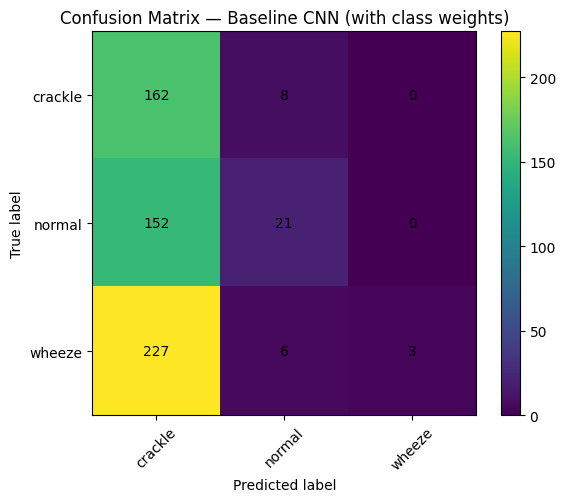

In [37]:
# Ground truth (val)
y_true = np.argmax(y_val, axis=1)

# Predictions
y_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)

plot_confusion_matrix(
    y_true,
    y_pred,
    class_names=le.classes_,
    title="Confusion Matrix — Baseline CNN (with class weights)"
)